In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import collections as mc
import datetime as dt
import matplotlib.dates as mdates

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Compute per-station coverages
See feature meanings: https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt

In [2]:
metadata_col_specs = [
    (0,  12),
    (12, 21),
    (21, 31),
    (31, 38),
    (38, 41),
    (41, 72),
    (72, 76),
    (76, 80),
    (80, 86)
]

metadata_names = [
    "ID",
    "LATITUDE",
    "LONGITUDE",
    "ELEVATION",
    "STATE",
    "NAME",
    "GSN FLAG",
    "HCN/CRN FLAG",
    "WMO ID"]

metadata_dtype = {
    "ID": str,
    "STATE": str,
    "NAME": str,
    "GSN FLAG": str,
    "HCN/CRN FLAG": str,
    "WMO ID": str
    }


# Data specs #

data_header_names = [
    "ID",
    "YEAR",
    "MONTH",
    "ELEMENT"]

data_header_col_specs = [
    (0,  11),
    (11, 15),
    (15, 17),
    (17, 21)]

data_header_dtypes = {
    "ID": str,
    "YEAR": int,
    "MONTH": int,
    "ELEMENT": str}

data_col_names = [[
    "VALUE" + str(i + 1),
    "MFLAG" + str(i + 1),
    "QFLAG" + str(i + 1),
    "SFLAG" + str(i + 1)]
    for i in range(31)]
# Join sub-lists
data_col_names = sum(data_col_names, [])

data_replacement_col_names = [[
    ("VALUE", i + 1),
    ("MFLAG", i + 1),
    ("QFLAG", i + 1),
    ("SFLAG", i + 1)]
    for i in range(31)]
# Join sub-lists
data_replacement_col_names = sum(data_replacement_col_names, [])
data_replacement_col_names = pd.MultiIndex.from_tuples(
    data_replacement_col_names,
    names=['VAR_TYPE', 'DAY'])

data_col_specs = [[
    (21 + i * 8, 26 + i * 8),
    (26 + i * 8, 27 + i * 8),
    (27 + i * 8, 28 + i * 8),
    (28 + i * 8, 29 + i * 8)]
    for i in range(31)]
data_col_specs = sum(data_col_specs, [])

data_col_dtypes = [{
    "VALUE" + str(i + 1): int,
    "MFLAG" + str(i + 1): str,
    "QFLAG" + str(i + 1): str,
    "SFLAG" + str(i + 1): str}
    for i in range(31)]
data_header_dtypes.update({k: v for d in data_col_dtypes for k, v in d.items()})


# Reading functions #

def read_station_metadata(filename="https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/ghcnd-stations.txt"):
    """Reads in station metadata

    :filename: ghcnd station metadata file.
    :returns: station metadata as a pandas Dataframe

    """
    df = pd.read_fwf(filename, metadata_col_specs, names=metadata_names,
                     index_col='ID', dtype=metadata_dtype)

    return df


def read_ghcn_data_file(station_id='USW00023183',
                        variables=None, include_flags=False,
                        dropna='all'):
    """Reads in all data from a GHCN .dly data file

    :param filename: path to file
    :param variables: list of variables to include in output dataframe
        e.g. ['TMAX', 'TMIN', 'PRCP']
    :param include_flags: Whether to include data quality flags in the final output
    :returns: Pandas dataframe
    """

    filename = 'https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/all/{}.dly'.format(station_id)
    
    df = pd.read_fwf(
        filename,
        colspecs=data_header_col_specs + data_col_specs,
        names=data_header_names + data_col_names,
        index_col=data_header_names,
        dtype=data_header_dtypes
        )

    if variables is not None:
        df = df[df.index.get_level_values('ELEMENT').isin(variables)]

    df.columns = data_replacement_col_names

    if not include_flags:
        df = df.loc[:, ('VALUE', slice(None))]
        df.columns = df.columns.droplevel('VAR_TYPE')

    df = df.stack(level='DAY').unstack(level='ELEMENT')

    if dropna:
        df.replace(-9999, np.nan, inplace=True)
#         df.dropna(how=dropna, inplace=True)

    # replace the entire index with the date.
    # This loses the station ID index column!
    # This will usuall fail if dropna=False, since months with <31 days
    # still have day=31 columns
    df.index = pd.to_datetime(
        df.index.get_level_values('YEAR') * 10000 +
        df.index.get_level_values('MONTH') * 100 +
        df.index.get_level_values('DAY'),
        format='%Y%m%d', errors='coerce')
    df.dropna(how=dropna, inplace=True)

    return df

In [ ]:
stations = read_station_metadata()
california_stations = stations[stations['STATE'] == 'NY']
stations['USW00094728':].head(1)

# california_stations

,LATITUDE,LONGITUDE,ELEVATION,STATE,NAME,GSN FLAG,HCN/CRN FLAG,WMO ID
ID,,,,,,,,
USW00094728,40.7789,-73.9692,39.6,NY,NEW YORK CNTRL PK TWR,NaN,HCN,72506


In [ ]:
california_station_ids = california_stations.index.tolist()
print(california_station_ids)

['US1CAAL0001', 'US1CAAL0002', 'US1CAAL0003', 'US1CAAL0004', 'US1CAAL0006', 'US1CAAL0007', 'US1CAAL0008', 'US1CAAL0011', 'US1CAAL0012', 'US1CAAL0015', 'US1CAAL0016', 'US1CAAL0017', 'US1CAAL0018', 'US1CAAL0020', 'US1CAAL0022', 'US1CAAL0024', 'US1CAAL0025', 'US1CAAL0030', 'US1CAAL0031', 'US1CAAL0032', 'US1CAAL0033', 'US1CAAL0035', 'US1CAAL0039', 'US1CAAL0045', 'US1CAAM0002', 'US1CAAM0003', 'US1CAAM0004', 'US1CAAM0005', 'US1CAAM0006', 'US1CAAM0007', 'US1CAAM0009', 'US1CAAM0010', 'US1CAAM0011', 'US1CAAM0013', 'US1CABT0002', 'US1CABT0003', 'US1CABT0005', 'US1CABT0007', 'US1CABT0008', 'US1CABT0009', 'US1CABT0010', 'US1CABT0011', 'US1CABT0012', 'US1CABT0013', 'US1CABT0015', 'US1CABT0016', 'US1CABT0017', 'US1CABT0018', 'US1CABT0019', 'US1CABT0023', 'US1CABT0026', 'US1CABT0032', 'US1CABT0033', 'US1CACC0001', 'US1CACC0003', 'US1CACC0004', 'US1CACC0006', 'US1CACC0007', 'US1CACC0008', 'US1CACC0010', 'US1CACC0011', 'US1CACC0012', 'US1CACC0013', 'US1CACC0014', 'US1CACC0016', 'US1CACC0018', 'US1CACC0

In [ ]:
california_data_coverages_list = []
california_date_ranges_list = []

for index, station_id in enumerate(california_station_ids):
    print(index)
    from_date = '2015-01-01'
    to_date = '2020-09-21'

    df = read_ghcn_data_file(station_id)
    df = df[df.index.to_series().between(from_date, to_date)]
    min_date = df.index.min()
    max_date = df.index.max()
    
    date_ranges = pd.DataFrame({'Station': [station_id], 'MinDate': [min_date], 'MaxDate': [max_date]})
    california_date_ranges_list.append(date_ranges)
    
    data_coverage = pd.DataFrame(df.notna().mean().round(4) * 100, columns=['Value'])
    data_coverage['Station'] = station_id
    california_data_coverages_list.append(data_coverage)

california_data_coverages = pd.concat(california_data_coverages_list)
california_data_coverages = california_data_coverages.reset_index().set_index(['Station'])
california_data_coverages.fillna(0, inplace=True)

california_date_ranges = pd.concat(california_date_ranges_list).set_index(['Station'])

california_data_coverages_summary = california_data_coverages.pivot(columns=['ELEMENT'], values=['Value']).fillna(0)
california_data_coverages_summary.columns = california_data_coverages_summary.columns.get_level_values(1)
california_data_coverages_summary = california_data_coverages_summary.reset_index(level=[0])

dated_california_data_coverages_summary = california_data_coverages_summary.merge(california_date_ranges, left_on='Station', right_index=True)
dated_california_data_coverages_summary.to_csv('california_data_coverages_summary_{}_{}.csv'.format(from_date, to_date))
dated_california_data_coverages_summary

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

,Station,ACMH,ACSH,AWDR,AWND,DAEV,DAPR,DASF,DAWM,EVAP,...,WT18,WT19,WT21,WT22,WV01,WV03,WV07,WV20,MinDate,MaxDate
0,US1CAAL0001,0.0,0.0,0.0,0.00,0.0,0.87,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2015-01-01,2020-09-21
1,US1CAAL0002,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaT,NaT
2,US1CAAL0003,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2015-01-01,2020-09-21
3,US1CAAL0004,0.0,0.0,0.0,0.00,0.0,1.42,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2015-01-01,2020-09-21
4,US1CAAL0006,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2015-02-07,2020-05-18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2793,USW00093241,0.0,0.0,0.0,99.71,0.0,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2015-01-01,2020-09-21
2794,USW00093242,0.0,0.0,0.0,99.47,0.0,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2015-01-01,2020-09-21
2795,USW00093243,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2015-01-01,2020-09-20
2796,USW00093245,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2015-01-01,2020-09-07


In [3]:
# Check single station
station_id = 'USW00094728'
from_date = '2015-01-01'
to_date = '2020-10-01'

df = read_ghcn_data_file(station_id)
df = df[df.index.to_series().between(from_date, to_date)]
min_date = df.index.min()
max_date = df.index.max()
# print(df.head)
# print(df.info(verbose=True))
data_coverage = pd.DataFrame(df.notna().mean().round(4) * 100, columns=['Value'])
data_coverage['Station'] = station_id
data_coverage['MinDate'] = min_date
data_coverage['MaxDate'] = max_date
data_coverage = data_coverage.reset_index().set_index(['Station'])
data_coverage.rename(columns={ 'ELEMENT' : 'DataType' }, inplace=True)
data_coverage

,DataType,Value,MinDate,MaxDate
Station,,,,
USW00094728,ACMH,0.00,2015-01-01,2020-10-01
USW00094728,ACSH,0.00,2015-01-01,2020-10-01
USW00094728,AWND,89.77,2015-01-01,2020-10-01
USW00094728,DAEV,0.00,2015-01-01,2020-10-01
USW00094728,DASF,0.00,2015-01-01,2020-10-01
USW00094728,DAWM,0.00,2015-01-01,2020-10-01
USW00094728,EVAP,0.00,2015-01-01,2020-10-01
USW00094728,FMTM,0.00,2015-01-01,2020-10-01
USW00094728,MDEV,0.00,2015-01-01,2020-10-01


In [15]:
# Get features for single station
station_id = 'USW00094728' # US1CAAL0001
from_date = '2015-01-01'
to_date = '2020-10-01'
features = ['TMAX', 'TMIN', 'PRCP', 'SNOW', 'AWND', 'SNWD', 'WDF2', 'WDF5', 'WSF2', 'WSF5']

df = read_ghcn_data_file(station_id)
df = df[df.index.to_series().between(from_date, to_date)][features].reset_index()
# df['Station'] = station_id
df.rename(columns={'index':'Date'}, inplace=True)
df = df[['Date'] + features]

df.to_csv('/content/drive/My Drive/SJSU Masters/CMPE 255/CMPE 255 Project/data/nooa_nyc_weather_features.csv', index=False)
df

ELEMENT,Date,TMAX,TMIN,PRCP,SNOW,AWND,SNWD,WDF2,WDF5,WSF2,WSF5
0,2015-01-01,39.0,-27.0,0.0,0.0,32.0,0.0,260.0,250.0,76.0,139.0
1,2015-01-02,56.0,17.0,0.0,0.0,32.0,0.0,260.0,310.0,67.0,112.0
2,2015-01-03,56.0,6.0,180.0,0.0,29.0,0.0,80.0,70.0,54.0,81.0
3,2015-01-04,133.0,50.0,76.0,0.0,29.0,0.0,280.0,260.0,130.0,206.0
4,2015-01-05,94.0,-60.0,0.0,0.0,47.0,0.0,280.0,300.0,107.0,170.0
...,...,...,...,...,...,...,...,...,...,...,...
2096,2020-09-27,261.0,194.0,8.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN
2097,2020-09-28,250.0,206.0,5.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN
2098,2020-09-29,233.0,194.0,119.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN
2099,2020-09-30,217.0,156.0,290.0,0.0,28.0,0.0,270.0,160.0,76.0,121.0


# See per-station coverage

In [ ]:
path = '/content/cmpe-255-data/california_data_coverages_summary_2010-01-01_2020-09-21.csv'
dated_california_data_coverages_summary = pd.read_csv(path)
dated_california_data_coverages_summary.drop(dated_california_data_coverages_summary.columns[0], axis=1, inplace=True)

dated_california_data_coverages_summary['MinDate'] = pd.to_datetime(dated_california_data_coverages_summary['MinDate'], format='%Y-%m-%d')
dated_california_data_coverages_summary['MaxDate'] = pd.to_datetime(dated_california_data_coverages_summary['MaxDate'], format='%Y-%m-%d')
dated_california_data_coverages_summary['MinYear'] = dated_california_data_coverages_summary['MinDate'].dt.year
dated_california_data_coverages_summary['MaxYear'] = dated_california_data_coverages_summary['MaxDate'].dt.year

dated_california_data_coverages_summary

,Station,ACMH,ACSH,AWDR,AWND,DAEV,DAPR,DASF,DAWM,EVAP,FMTM,FRGB,FRGT,FRTH,GAHT,MDEV,MDPR,MDSF,MDWM,MNPN,MXPN,PGTM,PRCP,PSUN,SN02,SN03,SN32,SN33,SN35,SNOW,SNWD,SX02,SX03,SX32,SX33,SX35,TAVG,THIC,TMAX,TMIN,...,WDFI,WDFM,WDMV,WESD,WESF,WSF1,WSF2,WSF5,WSFG,WSFI,WSFM,WT01,WT02,WT03,WT04,WT05,WT06,WT07,WT08,WT09,WT10,WT11,WT12,WT13,WT14,WT15,WT16,WT17,WT18,WT19,WT21,WT22,WV01,WV03,WV07,WV20,MinDate,MaxDate,MinYear,MaxYear
0,US1CAAL0001,0.0,0.0,0.0,0.00,0.0,0.91,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.91,0.0,0.0,0.0,0.0,0.00,99.06,0.00,0.0,0.0,0.0,0.0,0.0,81.39,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,...,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2010-01-01,2020-09-20,2010.0,2020.0
1,US1CAAL0002,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,100.00,0.00,0.0,0.0,0.0,0.0,0.0,73.20,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,...,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2010-01-01,2012-02-09,2010.0,2012.0
2,US1CAAL0003,0.0,0.0,0.0,0.00,0.0,0.19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.19,0.0,0.0,0.0,0.0,0.00,99.81,0.00,0.0,0.0,0.0,0.0,0.0,80.28,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,...,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2010-01-08,2020-09-21,2010.0,2020.0
3,US1CAAL0004,0.0,0.0,0.0,0.00,0.0,1.41,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.41,0.0,0.0,0.0,0.0,0.00,98.64,0.00,0.0,0.0,0.0,0.0,0.0,83.65,0.03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,...,0.0,0.0,0.0,0.03,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2010-01-01,2020-09-21,2010.0,2020.0
4,US1CAAL0006,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,100.00,0.00,0.0,0.0,0.0,0.0,0.0,0.55,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,...,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2010-01-12,2020-05-18,2010.0,2020.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2793,USW00093241,0.0,0.0,0.0,92.15,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,10.10,99.44,0.00,0.0,0.0,0.0,0.0,0.0,25.26,25.13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,99.97,99.97,...,0.0,0.0,0.0,0.00,0.0,0.0,92.20,91.46,0.0,0.0,0.0,18.66,2.56,0.56,0.0,0.0,0.0,0.0,8.41,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2010-01-01,2020-09-20,2010.0,2020.0
2794,USW00093242,0.0,0.0,0.0,96.65,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,18.89,99.95,0.00,0.0,0.0,0.0,0.0,0.0,80.42,81.09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,99.74,99.74,...,0.0,0.0,0.0,0.00,0.0,0.0,96.09,89.32,0.0,0.0,0.0,36.60,8.79,1.64,0.0,0.0,0.0,0.0,32.58,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2010-01-01,2020-09-20,2010.0,2020.0
2795,USW00093243,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,99.95,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,99.97,99.90,...,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2010-01-01,2020-09-19,2010.0,2020.0
2796,USW00093245,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,95.51,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,99.90,99.87,...,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0

### Possible metrics:

In [ ]:
# 81 orig vs 55 now with data
metrics = list(set(dated_california_data_coverages_summary.columns.tolist()) - set(['Station', 'MinDate', 'MaxDate', 'MinYear', 'MaxYear']))
df = dated_california_data_coverages_summary[metrics].stack().reset_index(name='Val').rename(columns={'level_1':'DataType'})
agg_metrics = df.groupby('DataType').sum()[['Val']]
viable_metrics = agg_metrics[agg_metrics['Val'] > 0].index.tolist()
print(viable_metrics)

['AWDR', 'AWND', 'DAPR', 'DASF', 'EVAP', 'MDPR', 'MDSF', 'MNPN', 'MXPN', 'PGTM', 'PRCP', 'PSUN', 'SN32', 'SN33', 'SN35', 'SNOW', 'SNWD', 'SX32', 'SX33', 'SX35', 'TAVG', 'TMAX', 'TMIN', 'TOBS', 'TSUN', 'WDF2', 'WDF5', 'WDFG', 'WDMV', 'WESD', 'WESF', 'WSF2', 'WSF5', 'WSFG', 'WSFI', 'WT01', 'WT02', 'WT03', 'WT04', 'WT05', 'WT06', 'WT07', 'WT08', 'WT09', 'WT10', 'WT11']


### Choose a metric from above to visualize

In [ ]:
# High Coverage: TMAX, TMIN, PRCP, SNOW
# Medium Coverage: SNWD
# Sparse Visble Coverage: EVAP, AWND, MNPN, MDPR, WDF2, WESD, WESF

metric = 'SNOW'

<Figure size 432x288 with 0 Axes>

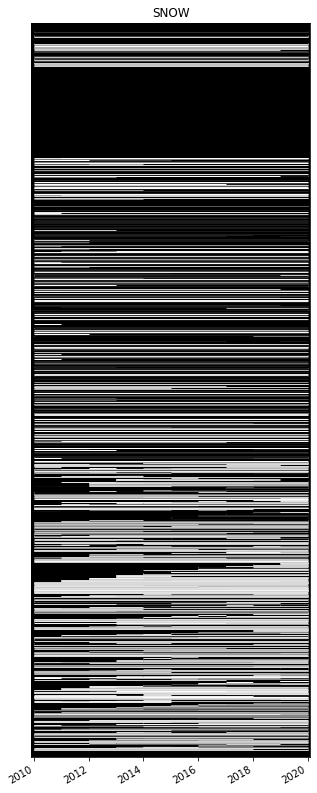

In [ ]:
data = dated_california_data_coverages_summary[['Station', metric, 'MinYear', 'MaxYear']]
intervals = [(row[2], row[3]) for row in data.values.tolist()]
values_str = [item[0] for item in data[[metric]].apply(lambda x: x / 100.0).astype(str).values.tolist()]

# Plot
plt.clf()
lines = [[(i[0], j), (i[1], j)] for i, j in zip(intervals, range(len(intervals)))]
lc = mc.LineCollection(lines, colors=values_str, linewidths=1)

fig, ax = plt.subplots(figsize=(5, 15))
ax.add_collection(lc)
ax.margins(0.01)
ax.set_facecolor('black')
plt.yticks([], [])
plt.gcf().autofmt_xdate()
plt.title(metric)
plt.show()
# https://stackoverflow.com/questions/56584939/matplotlibs-build-in-interval-plot

# Get features

In [4]:
# Get features for single station
station_id = 'USW00094728' # US1CAAL0001
from_date = '2015-01-01'
to_date = '2020-10-01'
features = ['TMAX', 'TMIN', 'PRCP', 'SNOW', 'AWND', 'SNWD', 'WDF2', 'WDF5', 'WSF2', 'WSF5']

station_feature_coverage = dated_california_data_coverages_summary[dated_california_data_coverages_summary['Station'] == station_id][features]
num_features_high_coverage = len(station_feature_coverage.loc[:, ~(station_feature_coverage < 0.9).all()].columns)
if (num_features_high_coverage == len(features)):
  print('Coverage high enough for {}'.format(features))

  df = read_ghcn_data_file(station_id)
  df = df[df.index.to_series().between(from_date, to_date)][features]
  df['Station'] = station_id
  print(df)

NameError: ignored

In [ ]:
# Get features for all CA stations
california_features_list = []

for index, station_id in enumerate(california_station_ids):
  from_date = '2010-01-01'
  to_date = '2020-09-23'
  features = ['TMAX', 'TMIN']

  station_feature_coverage = dated_california_data_coverages_summary[dated_california_data_coverages_summary['Station'] == station_id][features]
  num_features_high_coverage = len(station_feature_coverage.loc[:, ~(station_feature_coverage < 0.9).all()].columns)
  if (num_features_high_coverage == len(features)):
    print('Feature coverage high enough for {}: {}'.format(index, station_id))

    df = read_ghcn_data_file(station_id)
    df = df[df.index.to_series().between(from_date, to_date)][features]
    df['Station'] = station_id
    california_features_list.append(df)

california_features = pd.concat(california_features_list).reset_index()
california_features.rename(columns={'index':'Date'}, inplace=True) 
california_features = california_features[['Station', 'Date', 'TMIN', 'TMAX']]
california_features.to_csv('/content/cmpe-255-data/california_features_{}_{}.csv'.format(from_date, to_date))
california_features

Feature coverage high enough for 1134: USC00040136
Feature coverage high enough for 1136: USC00040161
Feature coverage high enough for 1137: USC00040174
Feature coverage high enough for 1138: USC00040176
Feature coverage high enough for 1140: USC00040192
Feature coverage high enough for 1142: USC00040212
Feature coverage high enough for 1145: USC00040232
Feature coverage high enough for 1153: USC00040332
Feature coverage high enough for 1154: USC00040343
Feature coverage high enough for 1157: USC00040379
Feature coverage high enough for 1158: USC00040383
Feature coverage high enough for 1166: USC00040436
Feature coverage high enough for 1169: USC00040444
Feature coverage high enough for 1170: USC00040449
Feature coverage high enough for 1171: USC00040503
Feature coverage high enough for 1176: USC00040521
Feature coverage high enough for 1186: USC00040673
Feature coverage high enough for 1194: USC00040693
Feature coverage high enough for 1199: USC00040738
Feature coverage high enough fo

ELEMENT,Station,Date,TMIN,TMAX
0,USC00040136,2010-01-01,67.0,217.0
1,USC00040136,2010-01-02,89.0,267.0
2,USC00040136,2010-01-03,100.0,256.0
3,USC00040136,2010-01-04,111.0,250.0
4,USC00040136,2010-01-05,83.0,239.0
...,...,...,...,...
2440257,USW00094299,2020-09-19,44.0,222.0
2440258,USW00094299,2020-09-20,-6.0,272.0
2440259,USW00094299,2020-09-21,0.0,278.0
2440260,USW00094299,2020-09-22,39.0,272.0
